# Import Libraries

In [299]:
import nltk
from nltk.stem.snowball import SnowballStemmer 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.ensemble import VotingClassifier
from nltk.probability import FreqDist
from matplotlib import cm
from wordcloud import WordCloud
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier

# Obtain Data

Read Yelp review data from csv

In [275]:
df = pd.read_csv('../yelp_reviews.csv')
df.head()

,Category,Review
0,gyms,I come to this location all the time and love ...
1,gyms,This place is definitely not meant for kids. I...
2,gyms,BKB Gowanus might share the same name as they'...
3,gyms,Have been coming here for about 6 months since...
4,gyms,Rowing itself is a great workout but I did not...


# Scrub Data: Pre-Processing

Create numerical dummy column for review class

In [297]:
df['Class'] = pd.get_dummies(df['Category'], drop_first=True)
df.iloc[1495:1505,:]

,Category,Review,Class
1495,gyms,First time trying SLT. Really good hard class....,1
1496,gyms,My friend and I who frequent these hybrid refo...,1
1497,gyms,It's a shame that this is such a beautiful and...,1
1498,gyms,"What a great idea, let's go to a spin cycle cl...",1
1499,gyms,I was excited to see Melissa back at BFX so I ...,1
1500,barbers,I moved to NYC in January and have been to Ace...,0
1501,barbers,Got a haircut in the shop today. Great quality...,0
1502,barbers,Literally the BEST experience I've ever had at...,0
1503,barbers,"Missing my barber, Izze, now more than ever. L...",0
1504,barbers,Izzy gave me probably one of the best haircuts...,0


Create list of tokenized gym reviews

In [277]:
gym_reviews = list(df[df['Class'] == 1]['Review'].values)
gym_tokens = []
for review in gym_reviews:
    gym_tokens.extend(nltk.word_tokenize(review))

Create list of tokenized barber reviews

In [278]:
barber_reviews = list(df[df['Class'] == 0]['Review'].values)
barber_tokens = []
for review in barber_reviews:
    barber_tokens.extend(nltk.word_tokenize(review))

Remove stopwords from gym and barber token lists

In [284]:
stop_words = stopwords.words('english')
stop_words.extend(['.','i',",",'!','s','gym','barber','barbers', '...',"'s","n't",'(',')',"'m",'ve','I'])
filtered_gym_tokens = []
for word in gym_tokens:
    if word not in stop_words:
        filtered_gym_tokens.append(word)
filtered_barber_tokens = [] 
for word in barber_tokens:
    if word not in stop_words:
        filtered_barber_tokens.append(word)

Stem gym and barber token lists

In [285]:
stemmer = SnowballStemmer('english')
stemmed_gym = [stemmer.stem(word) for word in filtered_gym_tokens]
stemmed_barber = [stemmer.stem(word) for word in filtered_barber_tokens]

# Explore Data

Create lists of 25 most frequent words and word counts for gym and barber classes

In [286]:
gym_freq = FreqDist(stemmed_gym)
barber_freq = FreqDist(stemmed_barber)
gym_freq_words = [x[0] for x in gym_freq.most_common(25)]
gym_freq_counts = [x[1] for x in gym_freq.most_common(25)]
barber_freq_words = [x[0] for x in barber_freq.most_common(25)]
barber_freq_counts = [x[1] for x in barber_freq.most_common(25)]

Create frequency distribution bar graphs for 25 most frequent words for gym and barber classes

Text(0, 0.5, 'Frequency')

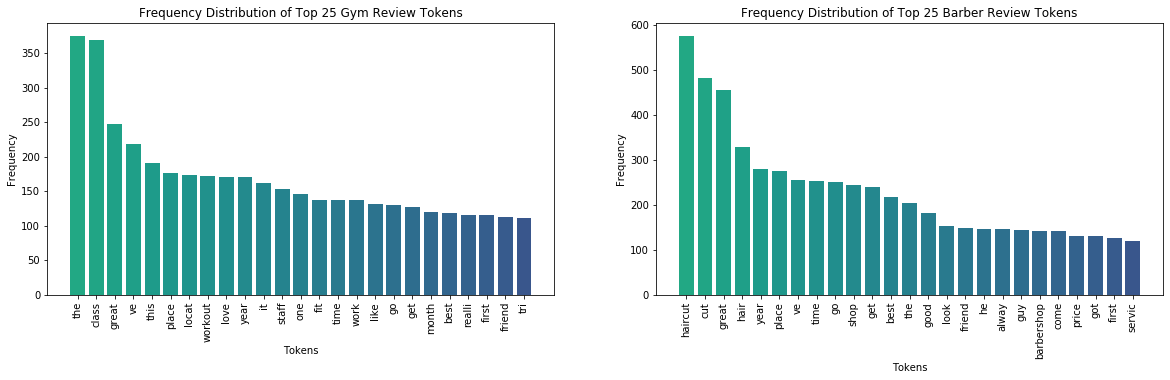

In [287]:
color = cm.viridis_r(np.linspace(.4,.8, 30))
fig, ax = plt.subplots(nrows = 1, ncols=2, figsize=(20,5))
ax[0].bar(gym_freq_words, gym_freq_counts, color=color)
ax[0].set_xticklabels(labels=gym_freq_words, rotation=90)
ax[0].set_title('Frequency Distribution of Top 25 Gym Review Tokens')
ax[0].set_xlabel('Tokens')
ax[0].set_ylabel('Frequency')
ax[1].bar(barber_freq_words, barber_freq_counts, color=color)
ax[1].set_xticklabels(labels=barber_freq_words, rotation=90)
ax[1].set_title('Frequency Distribution of Top 25 Barber Review Tokens')
ax[1].set_xlabel('Tokens')
ax[1].set_ylabel('Frequency')

Create word clouds for 25 most frequent words for gym and barber classes

[]

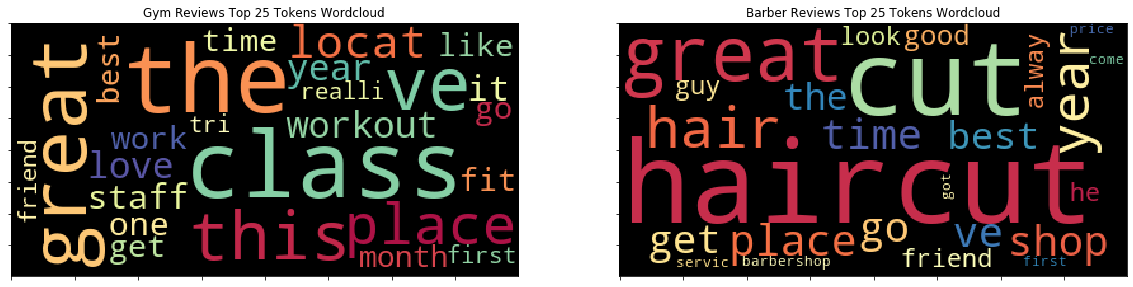

In [293]:
gym_freq_zipped = dict(zip(gym_freq_words, gym_freq_counts))
barber_freq_zipped = dict(zip(barber_freq_words, barber_freq_counts))
gym_wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(gym_freq_zipped)
barber_wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(barber_freq_zipped)
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,5))
ax[0].imshow(gym_wordcloud)
ax[0].set_title('Gym Reviews Top 25 Tokens Wordcloud')
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[1].imshow(barber_wordcloud)
ax[1].set_title('Barber Reviews Top 25 Tokens Wordcloud')
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])

# Model Data

Split Yelp review data into x and y variables

In [159]:
x = df['Review'].values
y = df['Class'].values

Perform train test split on Yelp review data

In [160]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=11, train_size = .2)

Vectorize Yelp review data using tf-idf

In [161]:
vectorizer = TfidfVectorizer(stop_words = stop_words)
vectorizer.fit(x_train)
tfidf_x_train = vectorizer.transform(x_train)
tfidf_x_test = vectorizer.transform(x_test)

Train baseline Dummy Classifier for Yelp review data

In [302]:
dummy = DummyClassifier(random_state=78)
dummy.fit(tfidf_x_train, y_train)
y_train_pred_dummy = dummy.predict(tfidf_x_train)
y_test_pred_dummy = dummy.predict(tfidf_x_test)
print('Train F1 Score: ', f1_score(y_train, y_train_pred_dummy))
print('Test F1 Score: ', f1_score(y_test, y_test_pred_dummy))

Train F1 Score:  0.5033783783783784
Test F1 Score:  0.4973017849730178


Perform GridSearchCV on Naive Bayes to find optimal alpha value

In [188]:
nb_dict = {'alpha': np.array(range(250,300))/1000}
gs_nb = MultinomialNB()
gs_nb = GridSearchCV(gs_nb, nb_dict, scoring='f1', n_jobs=-1, cv=5, verbose=1)
gs_nb.fit(tfidf_x_train, y_train)
gs_nb.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.5s finished


{'alpha': 0.277}

Train Naive Bayes model based on optimal alpha value from GridsearchCV

In [189]:
nb = MultinomialNB(alpha=.277)
nb.fit(tfidf_x_train, y_train)
y_train_pred = nb.predict(tfidf_x_train)
y_test_pred = nb.predict(tfidf_x_test)
print('Train F1 Score: ', f1_score(y_train, y_train_pred))
print('Test F1 Score: ', f1_score(y_test, y_test_pred))

Train F1 Score:  0.998324958123953
Test F1 Score:  0.8950323974082075


Create Confusion Matrix for Naive Bayes model

[Text(0, 0.5, 'Barber'), Text(0, 1.5, 'Gym')]

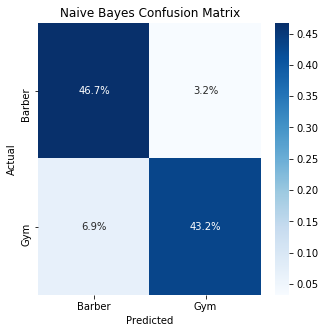

In [298]:
cm = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots(figsize=(5,5))
matrix = sns.heatmap(cm/np.sum(cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
matrix.set_title('Naive Bayes Confusion Matrix')
matrix.set_xlabel('Predicted')
matrix.set_xticklabels(['Barber','Gym'])
matrix.set_ylabel('Actual')
matrix.set_yticklabels(['Barber','Gym'])

Perform GridSearchCV on Random Forest to find optimal hyperparameters

rf_dict = {'max_leaf_nodes': range(10,35,5), 'n_estimators': [500, 1000, 1250]}
gs_rf = RandomForestClassifier()
gs_rf = GridSearchCV(gs_rf, rf_dict, scoring='f1', n_jobs=-1, cv=5, verbose=1)
gs_rf.fit(tfidf_x_train, y_train)
gs_rf.best_params_

Train Random Forest Classifier based on GridsearchCV results

In [213]:
rf = RandomForestClassifier(max_leaf_nodes=15, n_estimators=1250)
rf.fit(tfidf_x_train, y_train)
y_train_pred_rf = rf.predict(tfidf_x_train)
y_test_pred_rf = rf.predict(tfidf_x_test)
print('Train F1 Score: ', f1_score(y_train, y_train_pred_rf))
print('Test F1 Score: ', f1_score(y_test, y_test_pred_rf))

Train F1 Score:  0.9537480063795853
Test F1 Score:  0.8924302788844622


Create Confusion Matrix for Random Forest model

[Text(0, 0.5, 'Barber'), Text(0, 1.5, 'Gym')]

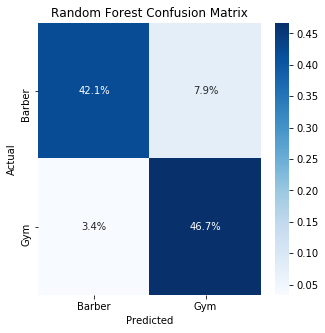

In [303]:
cm = confusion_matrix(y_test, y_test_pred_rf)
fig, ax = plt.subplots(figsize=(5,5))
matrix = sns.heatmap(cm/np.sum(cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
matrix.set_title('Random Forest Confusion Matrix')
matrix.set_xlabel('Predicted')
matrix.set_xticklabels(['Barber','Gym'])
matrix.set_ylabel('Actual')
matrix.set_yticklabels(['Barber','Gym'])

Train Gradient Boost model

In [249]:
gb = GradientBoostingClassifier(min_impurity_decrease=.2,n_estimators=150)
gb.fit(tfidf_x_train, y_train)
y_train_pred_gb = gb.predict(tfidf_x_train)
y_test_pred_gb = gb.predict(tfidf_x_test)
print('Train F1 Score: ', f1_score(y_train, y_train_pred_gb))
print('Test F1 Score: ', f1_score(y_test, y_test_pred_gb))

Train F1 Score:  1.0
Test F1 Score:  0.8771535580524344


Create Confusion Matrix for Gradient Boost model

[Text(0, 0.5, 'Barber'), Text(0, 1.5, 'Gym')]

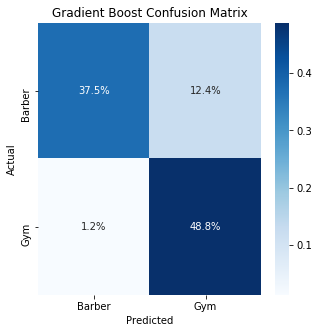

In [304]:
cm = confusion_matrix(y_test, y_test_pred_gb)
fig, ax = plt.subplots(figsize=(5,5))
matrix = sns.heatmap(cm/np.sum(cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
matrix.set_title('Gradient Boost Confusion Matrix')
matrix.set_xlabel('Predicted')
matrix.set_xticklabels(['Barber','Gym'])
matrix.set_ylabel('Actual')
matrix.set_yticklabels(['Barber','Gym'])

Train voting classifier model

In [257]:
vc = VotingClassifier(estimators=[('nb', nb), ('gb', gb), ('rf', rf)], voting='soft')
vc.fit(tfidf_x_train, y_train)
y_train_pred_vc = vc.predict(tfidf_x_train)
y_test_pred_vc = vc.predict(tfidf_x_test)
print('Train F1 Score: ', f1_score(y_train, y_train_pred_vc))
print('Test F1 Score: ', f1_score(y_test, y_test_pred_vc))

Train F1 Score:  1.0
Test F1 Score:  0.9142857142857143


Create Confusion Matrix for Voting Classifier model

[Text(0, 0.5, 'Barber'), Text(0, 1.5, 'Gym')]

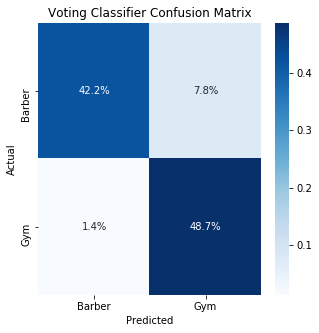

In [305]:
cm = confusion_matrix(y_test, y_test_pred_vc)
fig, ax = plt.subplots(figsize=(5,5))
matrix = sns.heatmap(cm/np.sum(cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
matrix.set_title('Voting Classifier Confusion Matrix')
matrix.set_xlabel('Predicted')
matrix.set_xticklabels(['Barber','Gym'])
matrix.set_ylabel('Actual')
matrix.set_yticklabels(['Barber','Gym'])